In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from random import choice
import random
import networkx as nx
import os
from pandas.io.json import json_normalize
import collections
import warnings
warnings.filterwarnings('ignore')

In [2]:
# SET CHANNEL PREFERENCES
channel_capacity_sats = 20000

In [3]:
# FUNCTIONS

# GET THE MAIN GRAPH
def get_main_subgraph(G):
    all_sub_G = list(nx.connected_component_subgraphs(G))
    largest_sg = 0
    for i, sg in enumerate(all_sub_G):
        if sg.number_of_nodes() > largest_sg:
            largest_sg = sg.number_of_nodes()
            main_G = sg
    return main_G


# CONNECT TO SELECTED NODES
def connect_to_new_neighbors(new_neighbors):
    for i in range(len(new_neighbors)):

        print("Setting up payment channel with "+node_alias[i]+"\n");
        connect = lightning_dir+"lightning-cli connect "+new_neighbors[i]+"@"+ip_address[i]
        print(connect)
    #     os.system(connect);

        fund_channel = lightning_dir+"lightning-cli fundchannel "+new_neighbors[i]+" "+str(channel_capacity_sats)
        print(fund_channel)
        print("\n")
    #     os.system(fund_channel);
    
    

# DISPLAY NEW NEIGHBOR INFO
def display_new_neighbors(G, new_neighbors):
    print("Do you want to connect to the following nodes?\n\n")
    node_alias=[]; num_channels=[]; ip_address=[]

    for i in range(len(new_neighbors)):
        nd = nodes_table[nodes_table['nodeid']==new_neighbors[i]]
        node_alias.append(str(nd['alias']))
        num_channels.append(len(list(G.neighbors(new_neighbors[i]))))
        ip_address.append(list(nd['addresses'])[0][0]['address'])
        print("node ID: "+new_neighbors[i])
        print("node alias: "+node_alias[i])
        print("number of channels: "+str(num_channels[i])+"\n")
       
    
# CREATE NEW GRAPH WITH NEW NODE AND EDGES
def make_graph_with_new_neighbors(G, new_neighbors):
    G_new = G.copy()
    G_new.add_node('new_node')
    new_edges = [('new_node',i) for i in new_neighbors]
    G_new.add_edges_from(new_edges)
    return(G_new)

In [4]:
# GET DATA
lightning_dir = "~/lightning/cli/"
save_dir = "> /Users/dariuscognac/Documents/GitHub/Lightning-Network-Topological-Analysis/"
listnodes = lightning_dir + "lightning-cli listnodes" + save_dir + "list_of_nodes.json"
listchannels = lightning_dir + "lightning-cli listchannels" + save_dir + "list_of_channels.json"

# os.system(listnodes);
# os.system(listchannels);


# LOAD AND FORMAT DATA
nodes_temp = pd.read_json('list_of_nodes.json')
nodes_table = json_normalize(nodes_temp['nodes'])
channels_temp = pd.read_json('list_of_channels.json')
channels_table = json_normalize(channels_temp['channels'])


# MAKE GRAPH
G = nx.Graph()
G.add_nodes_from(nodes_table['nodeid'])
edges_list = [(channels_table['source'][i], channels_table['destination'][i]) for i in range(len(channels_table))]
G.add_edges_from(edges_list)

G = get_main_subgraph(G)

print('Number of nodes = ' + str(len(G.nodes())))
print('Number of edges (payment channels) = ' + str(len(G.edges())))

Number of nodes = 1191
Number of edges (payment channels) = 4915


In [103]:
# FUNCTIONS FOR PICKING NEIGHBORS

# # RETURN NODES with highest percentile of centrality
# def pick_high_centrality_nodes(G, betweenness_percentile, num_channels_to_make):
#     # Compute the degree centrality of G: deg_cent      
#     deg_cent = nx.betweenness_centrality(G)
#     # Compute the X percentile of degree centrality
#     dc = list(deg_cent.values())
#     high_percentile_dc = np.percentile(dc, betweenness_percentile)
#     nodes = set()
#     # Iterate over the degree centrality dictionary
#     for k, v in deg_cent.items():
#         # Check if the current value has the maximum degree centrality
#         if v > high_percentile_dc:
#             # Add the current node to the set of nodes
#             nodes.add(k)
            
#     # Random sample from these highly connected nodes
#     new_neighbors = random.sample(nodes, num_channels_to_make)
#     return new_neighbors


# RETURN NODES with highest centrality
def pick_highest_centrality_nodes(G, num_channels_to_make):    
    between_centrality = get_centrality_dict(G, 'betweenness')
    bet_centrality = [(id, between_centrality.get(id)) for id in between_centrality]
    sorted_by_second = sorted(bet_centrality, key=lambda tup: tup[1], reverse=True) # Sort by betweenness centrality
    return [id for id, val in sorted_by_second[0: (num_channels_to_make)]]


def pick_poor_connected_nodes(G, min_degree, num_channels_to_make):
    degree = get_centrality_dict(G, 'degree')
    between_centrality = get_centrality_dict(G, 'betweenness')
    
    min_degree_nodes = set()
    for id, deg in degree.items():
        if deg > min_degree:
            min_degree_nodes.add(id)
            
    bet_centrality = [(id, between_centrality.get(id)) for id in min_degree_nodes]
    sorted_by_second = sorted(bet_centrality, key=lambda tup: tup[1]) # Sort by betweenness centrality
    return [id for id, val in sorted_by_second[0: (num_channels_to_make)]]

In [109]:
# PLOTTING FUNCTIONS

def plot_ego_graph(fig, ax, new_node_id, G, centrality_measure):
    # Create ego graphs
    ego_graph = nx.ego_graph(G, new_node_id, radius=2)
    immediate_graph = nx.ego_graph(G, new_node_id, radius=1)

    pos=nx.spring_layout(ego_graph, seed=1)
    centrality_dict = get_centrality_dict(G, centrality_measure)

    # Draw larger extended network 
    graph1_color_vals = [centrality_dict.get(node) for node in ego_graph.nodes()]
    nx.draw_networkx_nodes(ego_graph, ax=ax, pos=pos, cmap=plt.get_cmap('viridis'), 
            node_color=graph1_color_vals, node_size=100, alpha=0.6)
    nx.draw_networkx_edges(ego_graph, ax=ax, pos=pos, alpha=0.3, edge_color='grey')

    # Draw immediate network with stronger alpha
    graph2_color_vals = [centrality_dict.get(node) for node in immediate_graph.nodes()]
    nx.draw(immediate_graph, ax=ax, pos=pos, cmap=plt.get_cmap('viridis'), with_labels = False, 
            node_color=graph2_color_vals, node_size=400, alpha=1, edge_color='k', width = 5)
    
    # Create 'X' label for new node
    labels = {}    
    for node in immediate_graph.nodes():
        if node == new_node_id:
            #set the node name as the key and the label as its value 
            labels[node] = 'X'
    nx.draw_networkx_labels(immediate_graph, pos, labels, font_size=18, font_color='r', font_weight='bold', ax=ax)
    
    
def get_centrality_dict(G, centrality_measure):
    switcher = {
        'degree': dict(nx.degree(G)) ,
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G)
    }
    return switcher.get(centrality_measure)


def plot_centrality_hist(fig, ax, G, centrality_measure, new_node_id):
    centrality_dict = get_centrality_dict(G, centrality_measure)
    
    ax.hist(centrality_dict.values(),bins=25)
    ax.set_yscale('log')    
    node_centrality_value = centrality_dict.get(new_node_id)
    ax.axvline(x=node_centrality_value, color='r', linewidth=5)
    
    ax.title.set_text(centrality_measure + ' = ' + '%.2g' % node_centrality_value)
    

In [106]:
def plot_new_node_summary_fig(G, new_node_id):
    sns.set(font_scale=2)
    
    fig = plt.figure(0, figsize=(16,16))
    ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
    ax1 = plt.subplot2grid((3, 3), (2, 0))
    ax2 = plt.subplot2grid((3, 3), (2, 1))
    ax3 = plt.subplot2grid((3, 3), (2, 2))

    plot_ego_graph(fig, ax0, new_node_id, G, centrality_measure='betweenness')
    plot_centrality_hist(fig, ax1, G, centrality_measure='degree', new_node_id='new_node')
    plot_centrality_hist(fig, ax2, G, centrality_measure='betweenness', new_node_id='new_node')
    plot_centrality_hist(fig, ax3, G, centrality_measure='closeness', new_node_id='new_node')
    
    plt.show()

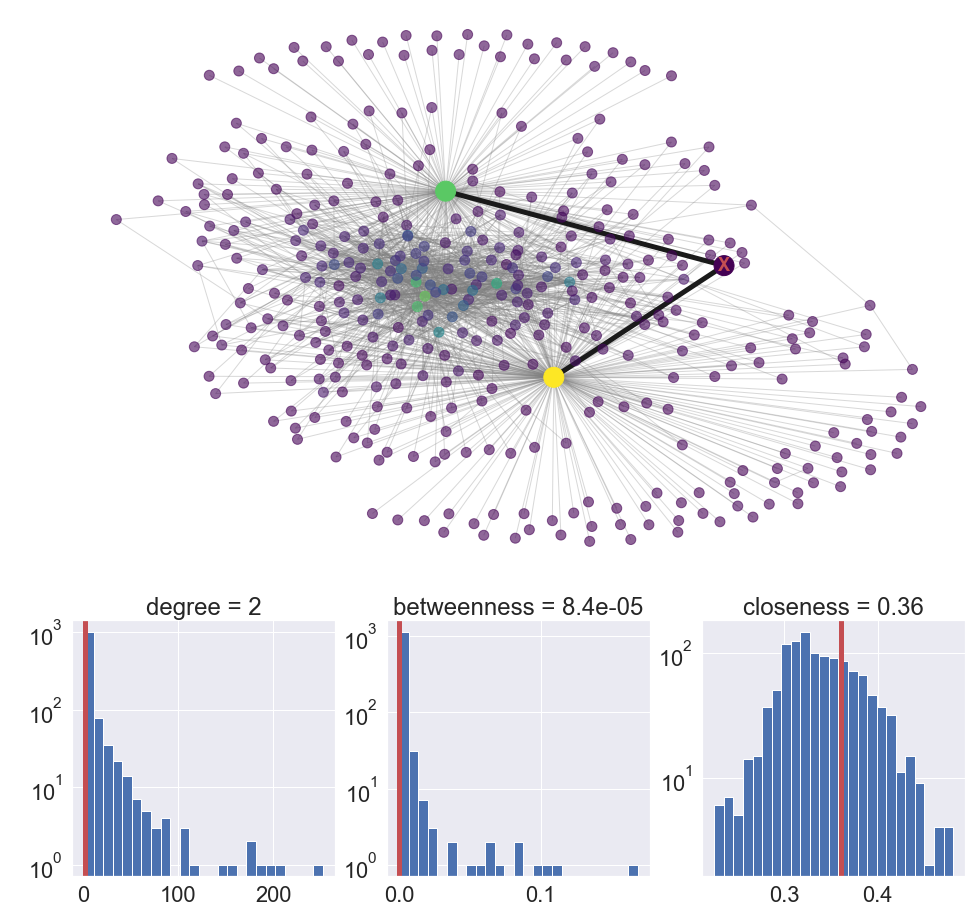

In [110]:
new_neighbors1 = pick_highest_centrality_nodes(G, 2)
G_new1 = make_graph_with_new_neighbors(G, new_neighbors1)
plot_new_node_summary_fig(G_new1, new_node_id='new_node')

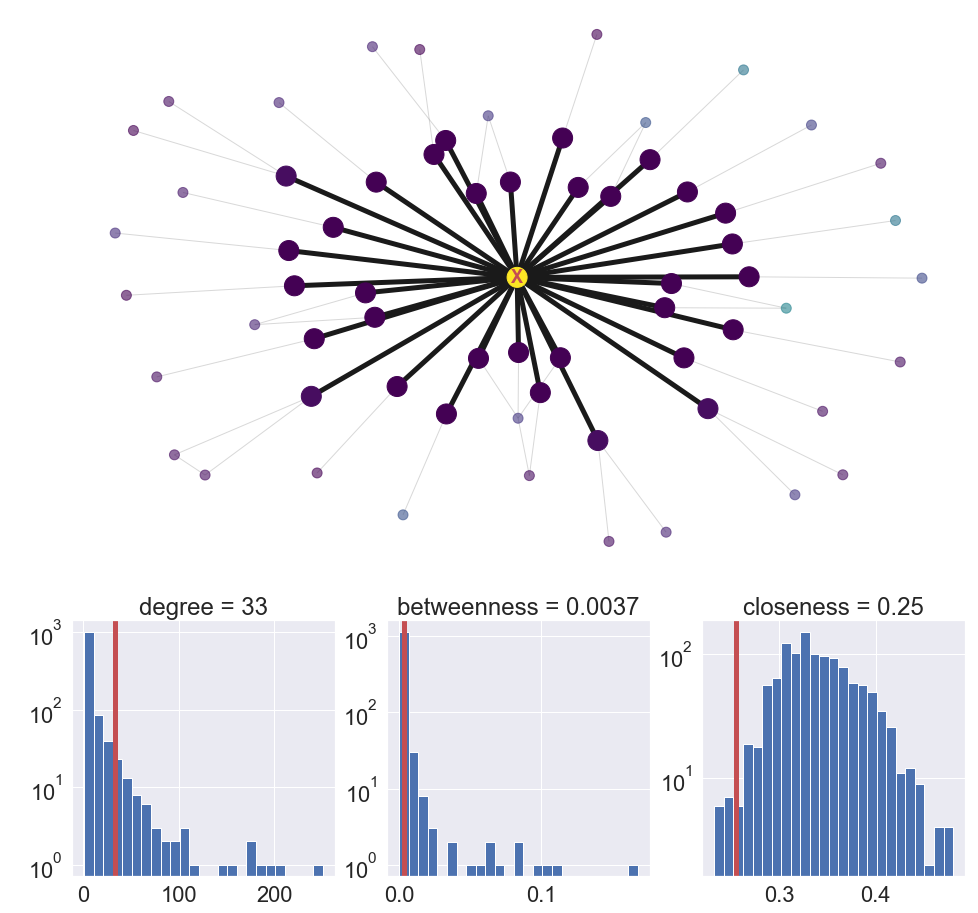

In [111]:
new_neighbors2 = nx.periphery(G)
G_new2 = make_graph_with_new_neighbors(G, new_neighbors2)
plot_new_node_summary_fig(G_new2, new_node_id='new_node')

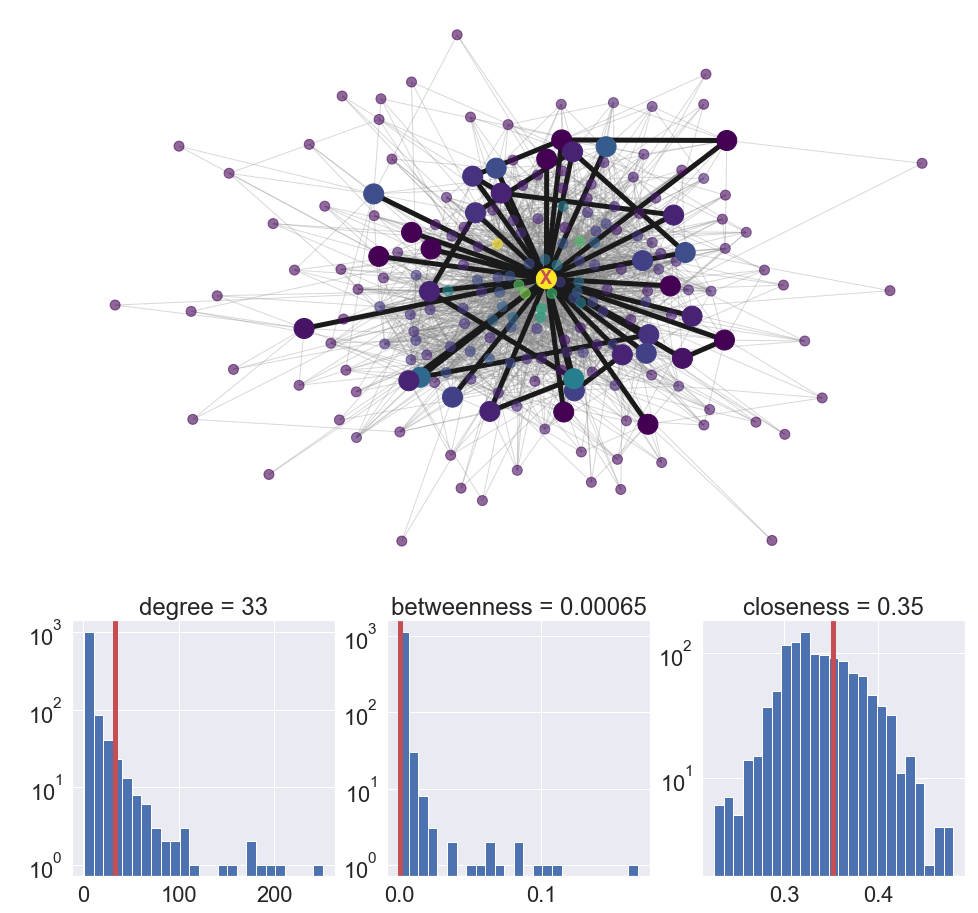

In [114]:
new_neighbors3 = pick_poor_connected_nodes(G, 10, 33)
G_new3 = make_graph_with_new_neighbors(G, new_neighbors3)
plot_new_node_summary_fig(G_new3, new_node_id='new_node')

In [ ]:
# connect_to_new_neighbors(new_neighbors)

In [ ]:
# degree = get_centrality_dict(G_new, 'degree')
# between_centrality = get_centrality_dict(G_new, 'betweenness')
# plt.scatter(x = list(between_centrality.values()), y = list(degree.values()));

In [ ]:
# peri = nx.periphery(G)

In [ ]:
nx.transitivity(G_new1)

In [ ]:
immediate_graph1 = nx.ego_graph(G_new2, 'new_node', radius=1)
nx.transitivity(immediate_graph1)

In [ ]:
immediate_graph1 = nx.ego_graph(G_new3, 'new_node', radius=2)
nx.transitivity(immediate_graph1)